# 3 Model Exploration

## 3.1 Imports and dataset loading

In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, auc
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

# Set visualization defaults
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


In [2]:
output_dir = '../output/'
df = pd.read_csv(output_dir + 'df_cleaned.csv')
print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")

Dataset loaded: 19701 rows, 41 columns


In [3]:
print("Dataset Info:")
print(df.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19701 entries, 0 to 19700
Data columns (total 41 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Any                        19701 non-null  int64  
 1   zona                       19701 non-null  int64  
 2   nomCom                     19701 non-null  int64  
 3   nomDem                     19701 non-null  int64  
 4   F_MORTS                    19701 non-null  int64  
 5   F_FERITS_GREUS             19701 non-null  int64  
 6   F_FERITS_LLEUS             19701 non-null  int64  
 7   F_VICTIMES                 19701 non-null  int64  
 8   F_UNITATS_IMPLICADES       19701 non-null  int64  
 9   F_VIANANTS_IMPLICADES      19701 non-null  int64  
 10  F_BICICLETES_IMPLICADES    19701 non-null  int64  
 11  F_CICLOMOTORS_IMPLICADES   19701 non-null  int64  
 12  F_MOTOCICLETES_IMPLICADES  19701 non-null  int64  
 13  F_VEH_LLEUGERS_IMPLICADES  19701

In [4]:
print("\nTarget variable distribution:")
print(df['Mortalitat'].value_counts().sort_index())
print("\nTarget proportions:")
print(df['Mortalitat'].value_counts(normalize=True).sort_index())



Target variable distribution:
Mortalitat
0    16789
1     2912
Name: count, dtype: int64

Target proportions:
Mortalitat
0    0.85219
1    0.14781
Name: proportion, dtype: float64


## 3.2 Data preparation and splits

### Separate features and target

In [5]:
# Remove features that directly encode the target, as seen in EDA
# F_MORTS (deaths), F_FERITS_GREUS (serious injuries), F_FERITS_LLEUS (light injuries), F_VICTIMES (victims)
# These should not be available at prediction time
leakage_features = ['F_MORTS', 'F_FERITS_GREUS', 'F_FERITS_LLEUS', 'F_VICTIMES']

X = df.drop(columns=['Mortalitat'] + leakage_features)
y = df['Mortalitat']

print(f"Removed leakage features: {leakage_features}")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures ({X.shape[1]} columns):")
print(X.columns.tolist())

Removed leakage features: ['F_MORTS', 'F_FERITS_GREUS', 'F_FERITS_LLEUS', 'F_VICTIMES']
Features shape: (19701, 36)
Target shape: (19701,)

Features (36 columns):
['Any', 'zona', 'nomCom', 'nomDem', 'F_UNITATS_IMPLICADES', 'F_VIANANTS_IMPLICADES', 'F_BICICLETES_IMPLICADES', 'F_CICLOMOTORS_IMPLICADES', 'F_MOTOCICLETES_IMPLICADES', 'F_VEH_LLEUGERS_IMPLICADES', 'F_VEH_PESANTS_IMPLICADES', 'C_VELOCITAT_VIA', 'D_BOIRA', 'D_CARACT_ENTORN', 'D_CARRIL_ESPECIAL', 'D_CIRCULACIO_MESURES_ESP', 'D_CLIMATOLOGIA', 'D_FUNC_ESP_VIA', 'D_INTER_SECCIO', 'D_LIMIT_VELOCITAT', 'D_LLUMINOSITAT', 'D_REGULACIO_PRIORITAT', 'D_SENTITS_VIA', 'D_SUBTIPUS_ACCIDENT', 'D_SUBTIPUS_TRAM', 'D_SUBZONA', 'D_SUPERFICIE', 'D_TIPUS_VIA', 'D_TITULARITAT_VIA', 'D_TRACAT_ALTIMETRIC', 'D_VENT', 'hor', 'grupHor', 'tipAcc', 'tipDia', 'Mes']


### Stratified Train/Val/Test split

In [6]:
# First split: 70% train, 30% temp (for validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Second split: 50% val, 50% test from temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Dataset splits:")
print(f"Train set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Val set:   {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test set:  {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

print("\nClass distribution across splits:")
print("\nTrain:")
print(y_train.value_counts(normalize=True).sort_index())
print("\nVal:")
print(y_val.value_counts(normalize=True).sort_index())
print("\nTest:")
print(y_test.value_counts(normalize=True).sort_index())


Dataset splits:
Train set: 13790 samples (70.0%)
Val set:   2955 samples (15.0%)
Test set:  2956 samples (15.0%)

Class distribution across splits:

Train:
Mortalitat
0    0.852212
1    0.147788
Name: proportion, dtype: float64

Val:
Mortalitat
0    0.852115
1    0.147885
Name: proportion, dtype: float64

Test:
Mortalitat
0    0.852165
1    0.147835
Name: proportion, dtype: float64


### Feature scaling

In [11]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert back to dfs
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Features scaled using RobustScaler")


Features scaled using RobustScaler


### Class weights (for imbalanced data)

In [8]:
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

print("Class Weights (for handling imbalance):")
print(f"Class 0 (No mortality): {class_weight_dict[0]:.4f}")
print(f"Class 1 (Mortality): {class_weight_dict[1]:.4f}")

Class Weights (for handling imbalance):
Class 0 (No mortality): 0.5867
Class 1 (Mortality): 3.3832


## 3.3 Model exploration

We want to explore different families of models and compare their performance using one same evaluation framework, so that we can select the best model for further hyperparameter tuning and analysis based on the observed trade-offs.

We will be storing an object per each model containing the model itself and its evaluation results, so that we can summarize and compare them later on.

In [17]:
def evaluate_model(model, X_train, X_val, X_test, y_train, y_val, y_test, model_name):
    """
    Comprehensive model evaluation on train, val, and test sets
    Also measures inference time on validation set
    """
    results = {}
    
    for set_name, X_set, y_set in [
        ('Train', X_train, y_train),
        ('Val', X_val, y_val),
        ('Test', X_test, y_test)
    ]:
        y_pred = model.predict(X_set)
        y_pred_proba = model.predict_proba(X_set)[:, 1] if hasattr(model, 'predict_proba') else None
        
        metrics = {
            'Accuracy': accuracy_score(y_set, y_pred),
            'Precision': precision_score(y_set, y_pred, zero_division=0),
            'Recall': recall_score(y_set, y_pred, zero_division=0),
            'F1': f1_score(y_set, y_pred, zero_division=0),
        }
        
        if y_pred_proba is not None:
            metrics['ROC-AUC'] = roc_auc_score(y_set, y_pred_proba)
        
        results[set_name] = metrics
    
    start_time = time.time()
    _ = model.predict(X_val)
    inference_time = (time.time() - start_time) / len(X_val) * 1000  # ms per sample
    results['Inference Time (ms/sample)'] = inference_time
    
    return results


def plot_confusion_matrix(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False,
                xticklabels=['No Mortality', 'Mortality'],
                yticklabels=['No Mortality', 'Mortality'])
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title(f'{model_name} - Confusion Matrix (Test Set)')
    plt.tight_layout()
    plt.show()
    
    print(f"\n{model_name} - Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Mortality', 'Mortality']))


### Logistic regression

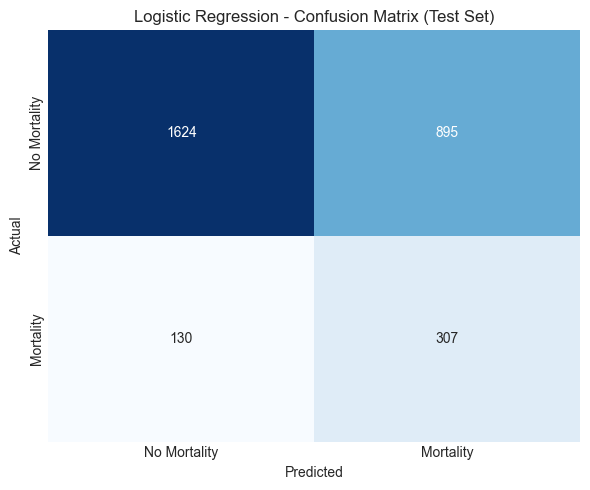


Logistic Regression - Classification Report:
              precision    recall  f1-score   support

No Mortality       0.93      0.64      0.76      2519
   Mortality       0.26      0.70      0.37       437

    accuracy                           0.65      2956
   macro avg       0.59      0.67      0.57      2956
weighted avg       0.83      0.65      0.70      2956



In [ ]:
lr = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

lr_train_start = time.time()
lr.fit(X_train_scaled, y_train)
lr_train_time = time.time() - lr_train_start

lr_results = evaluate_model(lr, X_train_scaled, X_val_scaled, X_test_scaled, 
                            y_train, y_val, y_test, 'Logistic Regression')

lr_info = {
    'model': lr,
    'training_time': lr_train_time,
    'inference_time': lr_results['Inference Time (ms/sample)'],
    'parameters': len(lr.coef_[0]),
    'test_results': lr_results['Test']
}

plot_confusion_matrix(lr, X_test_scaled, y_test, 'Logistic Regression')

### Decision tree

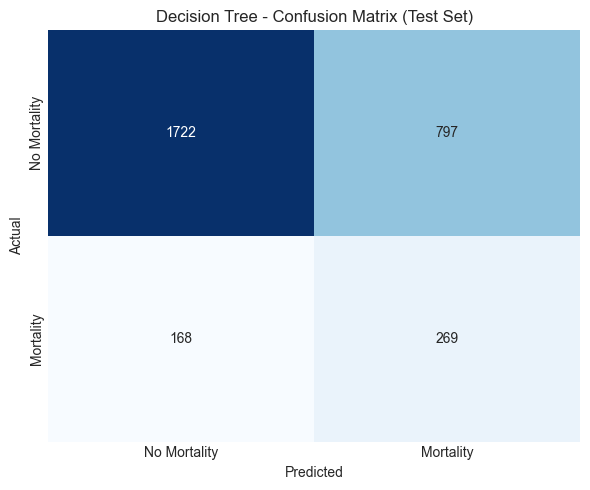


Decision Tree - Classification Report:
              precision    recall  f1-score   support

No Mortality       0.91      0.68      0.78      2519
   Mortality       0.25      0.62      0.36       437

    accuracy                           0.67      2956
   macro avg       0.58      0.65      0.57      2956
weighted avg       0.81      0.67      0.72      2956



In [ ]:
dt = DecisionTreeClassifier(
    class_weight='balanced',
    random_state=42,
    max_depth=10
)

dt_train_start = time.time()
dt.fit(X_train_scaled, y_train)
dt_train_time = time.time() - dt_train_start

dt_results = evaluate_model(dt, X_train_scaled, X_val_scaled, X_test_scaled,
                            y_train, y_val, y_test, 'Decision Tree')

dt_info = {
    'model': dt,
    'training_time': dt_train_time,
    'inference_time': dt_results['Inference Time (ms/sample)'],
    'parameters': dt.tree_.node_count,
    'test_results': dt_results['Test']
}

plot_confusion_matrix(dt, X_test_scaled, y_test, 'Decision Tree')

### Random forest

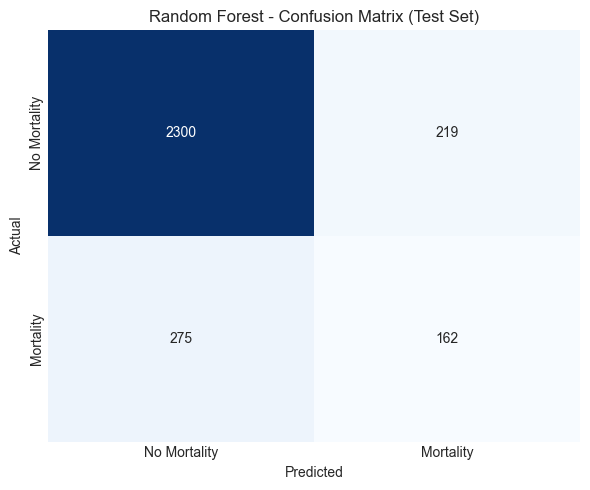


Random Forest - Classification Report:
              precision    recall  f1-score   support

No Mortality       0.89      0.91      0.90      2519
   Mortality       0.43      0.37      0.40       437

    accuracy                           0.83      2956
   macro avg       0.66      0.64      0.65      2956
weighted avg       0.82      0.83      0.83      2956



In [ ]:
rf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    max_depth=15
)

rf_train_start = time.time()
rf.fit(X_train_scaled, y_train)
rf_train_time = time.time() - rf_train_start

rf_results = evaluate_model(rf, X_train_scaled, X_val_scaled, X_test_scaled,
                            y_train, y_val, y_test, 'Random Forest')

rf_info = {
    'model': rf,
    'training_time': rf_train_time,
    'inference_time': rf_results['Inference Time (ms/sample)'],
    'parameters': sum(t.tree_.node_count for t in rf.estimators_),
    'test_results': rf_results['Test']
}

plot_confusion_matrix(rf, X_test_scaled, y_test, 'Random Forest')

### XGBoost classifier

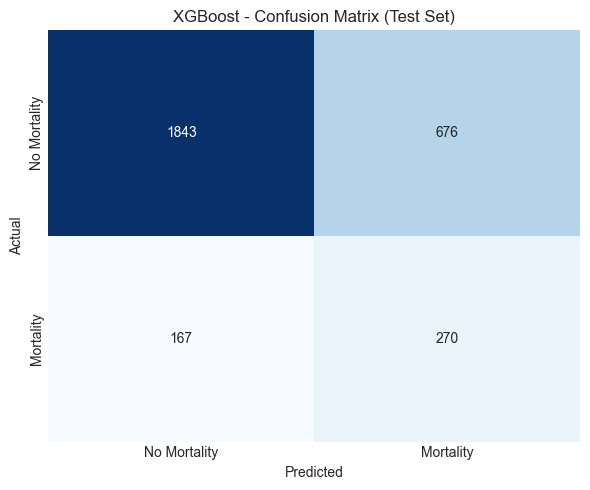


XGBoost - Classification Report:
              precision    recall  f1-score   support

No Mortality       0.92      0.73      0.81      2519
   Mortality       0.29      0.62      0.39       437

    accuracy                           0.71      2956
   macro avg       0.60      0.67      0.60      2956
weighted avg       0.82      0.71      0.75      2956



In [ ]:
xgb = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=class_weight_dict[1] / class_weight_dict[0],
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

xgb_train_start = time.time()
xgb.fit(X_train_scaled, y_train)
xgb_train_time = time.time() - xgb_train_start

xgb_results = evaluate_model(xgb, X_train_scaled, X_val_scaled, X_test_scaled,
                             y_train, y_val, y_test, 'XGBoost')

xgb_info = {
    'model': xgb,
    'training_time': xgb_train_time,
    'inference_time': xgb_results['Inference Time (ms/sample)'],
    'parameters': xgb.n_estimators * 5,  # Approximate
    'test_results': xgb_results['Test']
}

plot_confusion_matrix(xgb, X_test_scaled, y_test, 'XGBoost')

### Gradient boosting

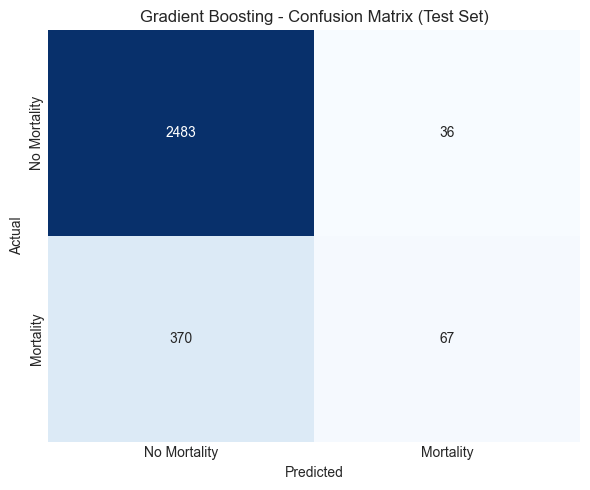


Gradient Boosting - Classification Report:
              precision    recall  f1-score   support

No Mortality       0.87      0.99      0.92      2519
   Mortality       0.65      0.15      0.25       437

    accuracy                           0.86      2956
   macro avg       0.76      0.57      0.59      2956
weighted avg       0.84      0.86      0.82      2956



In [ ]:
gb = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

gb_train_start = time.time()
gb.fit(X_train_scaled, y_train)
gb_train_time = time.time() - gb_train_start

gb_results = evaluate_model(gb, X_train_scaled, X_val_scaled, X_test_scaled,
                            y_train, y_val, y_test, 'Gradient Boosting')

gb_info = {
    'model': gb,
    'training_time': gb_train_time,
    'inference_time': gb_results['Inference Time (ms/sample)'],
    'parameters': sum(t.tree_.node_count for t in gb.estimators_.ravel()),
    'test_results': gb_results['Test']
}

plot_confusion_matrix(gb, X_test_scaled, y_test, 'Gradient Boosting')

### Support Vector Machine

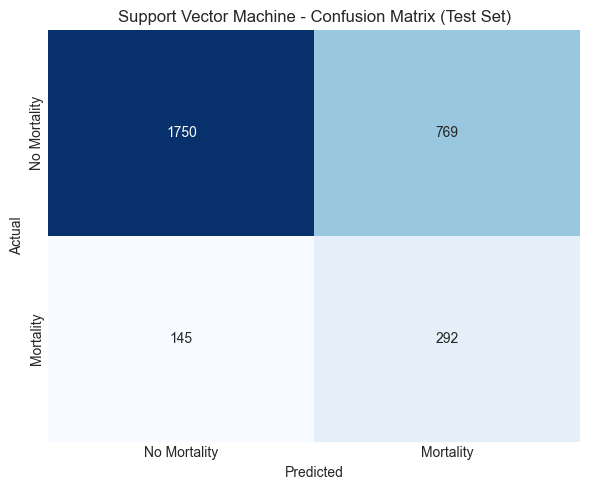


Support Vector Machine - Classification Report:
              precision    recall  f1-score   support

No Mortality       0.92      0.69      0.79      2519
   Mortality       0.28      0.67      0.39       437

    accuracy                           0.69      2956
   macro avg       0.60      0.68      0.59      2956
weighted avg       0.83      0.69      0.73      2956



In [ ]:
svm = SVC(
    kernel='rbf',
    class_weight='balanced',
    random_state=42,
    probability=True
)

svm_train_start = time.time()
svm.fit(X_train_scaled, y_train)
svm_train_time = time.time() - svm_train_start

svm_results = evaluate_model(svm, X_train_scaled, X_val_scaled, X_test_scaled,
                             y_train, y_val, y_test, 'SVM')

svm_info = {
    'model': svm,
    'training_time': svm_train_time,
    'inference_time': svm_results['Inference Time (ms/sample)'],
    'parameters': len(svm.support_vectors_),
    'test_results': svm_results['Test']
}

plot_confusion_matrix(svm, X_test_scaled, y_test, 'Support Vector Machine')

## 3.4 Model comparison

### Accuracy and predictive performance trade-offs

In [27]:
# Create comprehensive comparison dataframe
models_info = {
    'Logistic Regression': lr_info,
    'Decision Tree': dt_info,
    'Random Forest': rf_info,
    'XGBoost': xgb_info,
    'Gradient Boosting': gb_info,
    'SVM': svm_info
}

# Extract test set F1 scores for comparison
test_f1_scores = {}
for model_name, info in models_info.items():
    test_f1_scores[model_name] = info['test_results']['F1']

comparison_df = pd.DataFrame(test_f1_scores, index=['F1 Score']).T
comparison_df = comparison_df.sort_values('F1 Score', ascending=False)

print("\n" + "="*80)
print("TEST SET PERFORMANCE COMPARISON (F1 Score)")
print("="*60)
print(comparison_df)

# Full comparison table
print("\n" + "="*80)
print("DETAILED TEST SET COMPARISON")
print("="*60)
detailed_comparison = pd.DataFrame({
    model: info['test_results'] for model, info in models_info.items()
}).T
print(detailed_comparison)



TEST SET PERFORMANCE COMPARISON (F1 Score)
                     F1 Score
Random Forest        0.396088
XGBoost              0.390456
SVM                  0.389853
Logistic Regression  0.374619
Decision Tree        0.357951
Gradient Boosting    0.248148

DETAILED TEST SET COMPARISON
                     Accuracy  Precision    Recall        F1   ROC-AUC
Logistic Regression  0.653248   0.255408  0.702517  0.374619  0.719655
Decision Tree        0.673545   0.252345  0.615561  0.357951  0.654468
Random Forest        0.832882   0.425197  0.370709  0.396088  0.753263
XGBoost              0.714817   0.285412  0.617849  0.390456  0.753826
Gradient Boosting    0.862652   0.650485  0.153318  0.248148  0.762747
SVM                  0.690798   0.275212  0.668192  0.389853  0.735414


### Complexity and performance trade-offs

In [26]:
complexity_analysis = {
    'Logistic Regression': {
        'Parameters': lr_info['parameters'],
        'Inference Time (ms/sample)': lr_info['inference_time'],
        'Training Time (seconds)': lr_info['training_time']
    },
    'Decision Tree': {
        'Parameters': dt_info['parameters'],
        'Inference Time (ms/sample)': dt_info['inference_time'],
        'Training Time (seconds)': dt_info['training_time']
    },
    'Random Forest': {
        'Parameters': rf_info['parameters'],
        'Inference Time (ms/sample)': rf_info['inference_time'],
        'Training Time (seconds)': rf_info['training_time']
    },
    'XGBoost': {
        'Parameters': xgb_info['parameters'],
        'Inference Time (ms/sample)': xgb_info['inference_time'],
        'Training Time (seconds)': xgb_info['training_time']
    },
    'Gradient Boosting': {
        'Parameters': gb_info['parameters'],
        'Inference Time (ms/sample)': gb_info['inference_time'],
        'Training Time (seconds)': gb_info['training_time']
    },
    'SVM': {
        'Parameters': svm_info['parameters'],
        'Inference Time (ms/sample)': svm_info['inference_time'],
        'Training Time (seconds)': svm_info['training_time']
    }
}

complexity_df = pd.DataFrame(complexity_analysis).T
print(complexity_df)

                     Parameters  Inference Time (ms/sample)  \
Logistic Regression        36.0                    0.000151   
Decision Tree             801.0                    0.000248   
Random Forest          231450.0                    0.004592   
XGBoost                   500.0                    0.000512   
Gradient Boosting        5346.0                    0.001669   
SVM                      9676.0                    0.642787   

                     Training Time (seconds)  
Logistic Regression                 1.464556  
Decision Tree                       0.112901  
Random Forest                       0.216139  
XGBoost                             0.253088  
Gradient Boosting                   2.414597  
SVM                                24.411522  
